## 1.

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA
%matplotlib inline

In [3]:
df = pd.read_csv('train.csv')
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


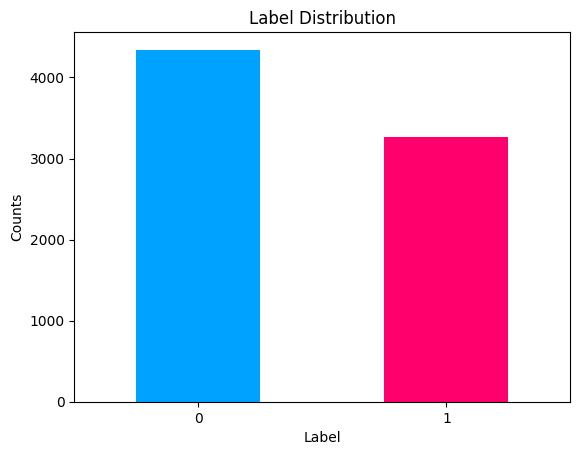

In [4]:
# Plot targets
df['target'].value_counts().plot.bar(width=0.5, color=['#00a2ff', '#ff006c'], rot=0)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.xticks(ticks=[0, 1])
plt.show()

Βλέπουμε ότι τα 0 είναι περισσότερα από τα 1, οπότε τα labels δεν είναι ισορροπημένα.


## 2.

In [5]:
def preprocess_data(x):
  x_new = x.drop(columns=['id', 'location'])
  x_new = x_new.fillna('null')

  x_new['inputs'] = x_new['keyword']+' '+df['text']
  x_new = x_new.drop(columns=['keyword', 'text'])
  return x_new

In [6]:
df = preprocess_data(df)

In [7]:
df.head()

,target,inputs
0,1,null Our Deeds are the Reason of this #earthqu...
1,1,null Forest fire near La Ronge Sask. Canada
2,1,null All residents asked to 'shelter in place'...
3,1,"null 13,000 people receive #wildfires evacuati..."
4,1,null Just got sent this photo from Ruby #Alask...


## 3.

In [8]:
def text_processing(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)
    text = re.sub(r'[^\x00-\x7f]',r'',text)

    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)

    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','atUser',text)

    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)

    """ Replaces contractions from a string to their equivalents """
    contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]

    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)

    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text


Χρησιμοποίησα τις παραπάνω μεθόδους καθαρισμού text γιατί τα συντακτικά στοιχείο και τα emojis δεν παρέχουν κάποια χρήσιμη πληροφορία για την μηχανή.

Τα urls μπορεί στην διέυθυνση να περιέχουν άσχετες λέξεις και λέξεις περιέργεις και random γράμματα και αριθμούς και να μπερδέυουν το μοντέλο. Το ίδιο και με τα user names.

Γενικά τα hashtags μπορεί να περιέχουν χρήσιμη πληροφορία αλλά το '#' είναι αχρείαστο και τζάμπα πιάνει μνήμη οπότε το αφαιρούμε και κρατάμε την λέξη.

ΑΦαιρούμε τις συντομογραφίες και την αντικαθιστούμε με ολόκληρες λέξεις για να μην μπερδεύουμε το μοντέλο.

In [9]:
# Example of raw text sample
print(df['inputs'].iloc[5])
print(df['inputs'].iloc[68])

null #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
accident Accident on I-24 W #NashvilleTraffic. Traffic moving 8m slower than usual. https://t.co/0GHk693EgJ


In [10]:
df_clean = df.copy()
df_clean['inputs'] = df_clean['inputs'].apply(text_processing)

In [11]:
print(df_clean['inputs'].iloc[5])
print(df_clean['inputs'].iloc[68])

null RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - CAfire wildfires
accident Accident on I-24 W NashvilleTraffic. Traffic moving 8m slower than usual. url


## 4.

In [12]:
inputs = np.array(df_clean.drop(columns='target'))
targets = np.array(df_clean['target'])

In [13]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, train_size=0.9, random_state=0, stratify=targets)
x_train = np.squeeze(x_train)
x_test = np.squeeze(x_test)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(6851,) (6851,)
(762,) (762,)


## 5.

In [14]:
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)
print(train_vectors.shape, test_vectors.shape)

(6851, 14271) (762, 14271)


## 6.

In [15]:
acc_scores = []
f1_scores = []
rec_scores = []
pre_scores = []
scores_labels = ['linear no-pca', 'linear', 'rbf scale', 'rbf auto']

In [16]:
svm = SVC(kernel='linear')
svm.fit(train_vectors, y_train)

train_pred = svm.predict(train_vectors)
test_pred = svm.predict(test_vectors)

print('Accuracy in train set:', accuracy_score(train_pred, y_train))
print('Accuracy in test set:', accuracy_score(test_pred, y_test))
acc_scores.append(accuracy_score(test_pred, y_test))
print('\nF1 score in train set:', f1_score(train_pred, y_train))
print('F1 score in test set:', f1_score(test_pred, y_test))
f1_scores.append(f1_score(test_pred, y_test))
print('\nPrecision in train set:', precision_score(train_pred, y_train))
print('Precision in test set:', precision_score(test_pred, y_test))
pre_scores.append(precision_score(test_pred, y_test))
print('\nRecall in train set:', recall_score(train_pred, y_train))
print('Recall in test set:', recall_score(test_pred, y_test))
rec_scores.append(recall_score(test_pred, y_test))

Accuracy in train set: 0.9083345497007737
Accuracy in test set: 0.8241469816272966

F1 score in train set: 0.8866425992779784
F1 score in test set: 0.7817589576547231

Precision in train set: 0.8342391304347826
Precision in test set: 0.7339449541284404

Recall in train set: 0.9460708782742681
Recall in test set: 0.8362369337979094


Η μετρκή accuracy σίγουρα δεν είναι η καλύτερη διότι οι κλάσεις δεν είναι ισορροπημένες.

Η precision θα ήταν πιο σημαντική στην περίπτωση που ο αλγόριθμος θα τρέχει σε ένα σύστημα που την στιγμή που ανιχνεύσει κάποια καταστροφή, θα ειδοποιεί άμεσσα σώματα ασφαλείας και πυροσβεστική για να κινητοποιηθούν. Σε αυτή την περίπτωση μας ενδιαφέρει το σύστημα να προβλέπει με μεγάλη ακρίβεια τα θετικά ώστε να μην σπαταλάμε τζάμπα πόρους και να είναι απασχολημένα τα σώματα με περιπτώσεις που ο αλγόριθμος έκανε λάθος, με αποτέλεσμα να μην έχουμε σώματα για να στείλουμε σε πραγματικές περιπτώσεις καταστροφών.

Η recall θα ήταν πιο σωημαντική στην περίπτωση που τα σήματα από το σύστημα περνάνε από ανθρώπινο review για να επιβεβαιωθεί ότι υπάρχει κίνδυνος. Σε αυτή την περίπτωση θέλομυε να πιάσουμε όσο το δυνατόν περισσότερα θετικά με λιγότερη ακρίβεια, καθώς ούτως η αλλός αυτά θα ελεγχθούν και θα βρούμε ποιά είναι πραγματικά σήματα.

Η F1-score είναι ένα ενδιάμεσο ανάμεσα στα precision και recall, και μπορεί να χρησιμοποιηθεί και στις δύο περιπτώσεις ως μία πιο loose επιλογή (καθώς είναι πιο χαλαρή από την precision, αλλά πιο strict από την recall).



## 7.

In [17]:
pca = PCA(n_components=0.95, svd_solver='full')
pca_train = pca.fit_transform(train_vectors.toarray())
pca_test = pca.transform(test_vectors.toarray())

svm = SVC(kernel='linear')
svm.fit(pca_train, y_train)

train_pred = svm.predict(pca_train)
test_pred = svm.predict(pca_test)

print('Accuracy in train set:', accuracy_score(train_pred, y_train))
print('Accuracy in test set:', accuracy_score(test_pred, y_test))
acc_scores.append(accuracy_score(test_pred, y_test))
print('\nF1 score in train set:', f1_score(train_pred, y_train))
print('F1 score in test set:', f1_score(test_pred, y_test))
f1_scores.append(f1_score(test_pred, y_test))
print('\nPrecision in train set:', precision_score(train_pred, y_train))
print('Precision in test set:', precision_score(test_pred, y_test))
pre_scores.append(precision_score(test_pred, y_test))
print('\nRecall in train set:', recall_score(train_pred, y_train))
print('Recall in test set:', recall_score(test_pred, y_test))
rec_scores.append(recall_score(test_pred, y_test))

Accuracy in train set: 0.8985549554809517
Accuracy in test set: 0.8254593175853019

F1 score in train set: 0.8742991499366974
F1 score in test set: 0.7837398373983739

Precision in train set: 0.8209918478260869
Precision in test set: 0.7370030581039755

Recall in train set: 0.935009671179884
Recall in test set: 0.8368055555555556


In [18]:
svm = SVC(kernel='rbf')
svm.fit(pca_train, y_train)

train_pred = svm.predict(pca_train)
test_pred = svm.predict(pca_test)

print('Accuracy in train set:', accuracy_score(train_pred, y_train))
print('Accuracy in test set:', accuracy_score(test_pred, y_test))
acc_scores.append(accuracy_score(test_pred, y_test))
print('\nF1 score in train set:', f1_score(train_pred, y_train))
print('F1 score in test set:', f1_score(test_pred, y_test))
f1_scores.append(f1_score(test_pred, y_test))
print('\nPrecision in train set:', precision_score(train_pred, y_train))
print('Precision in test set:', precision_score(test_pred, y_test))
pre_scores.append(precision_score(test_pred, y_test))
print('\nRecall in train set:', recall_score(train_pred, y_train))
print('Recall in test set:', recall_score(test_pred, y_test))
rec_scores.append(recall_score(test_pred, y_test))

Accuracy in train set: 0.9470150343015619
Accuracy in test set: 0.8136482939632546

F1 score in train set: 0.9359449444150344
F1 score in test set: 0.7738853503184714

Precision in train set: 0.9008152173913043
Precision in test set: 0.7431192660550459

Recall in train set: 0.9739258171134778
Recall in test set: 0.8073089700996677


Βλέπουμε ότι σε σχέση με τον linear, η απόδοση του rbf στα train δεδομένα είναι υψηλότερη ενώ στα test είναι μικρότερη. Αυτό δεν σημαίνει απαραίτητα ότι το linear τα πάει καλύτερα στο test, καθώς το rbf μπορεί να έχει κάνει overfit τα δεδομένα και αν πειράξουμε λίγο την παράμετρο C να βελτιωθεί το test.

## 8.

Η τιμή της παραμέτρου `gamma` από default είναι `'scale'`, δηλαδή $\dfrac{1}{n_{features} * X.var()}$. Η τιμή `'auto'` υπολογίζεται ως $\dfrac{1}{n_{features}}$

In [19]:
svm = SVC(kernel='rbf', gamma='auto')
svm.fit(pca_train, y_train)

train_pred = svm.predict(pca_train)
test_pred = svm.predict(pca_test)

print('Accuracy in train set:', accuracy_score(train_pred, y_train))
print('Accuracy in test set:', accuracy_score(test_pred, y_test))
acc_scores.append(accuracy_score(test_pred, y_test))
print('\nF1 score in train set:', f1_score(train_pred, y_train))
print('F1 score in test set:', f1_score(test_pred, y_test))
f1_scores.append(f1_score(test_pred, y_test))
print('\nPrecision in train set:', precision_score(train_pred, y_train))
print('Precision in test set:', precision_score(test_pred, y_test))
pre_scores.append(precision_score(test_pred, y_test))
print('\nRecall in train set:', recall_score(train_pred, y_train))
print('Recall in test set:', recall_score(test_pred, y_test))
rec_scores.append(recall_score(test_pred, y_test))

Accuracy in train set: 0.570281710699168
Accuracy in test set: 0.5708661417322834

F1 score in train set: 0.0
F1 score in test set: 0.0

Precision in train set: 0.0
Precision in test set: 0.0

Recall in train set: 0.0
Recall in test set: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Το μοντέλο τα πάει πάρα πολύ χάλια. Αυτό συμβαίνει γιατί το gamma είναι αντιστρόφως ανάλογο τον χαρακτηριστικών, και τα χαρακτηριστικά είναι πάρα πολλά και έτσι το gamma παίρνει παρά πολύ μικρή τιμή και γενικεύει πάρα πολύ.

In [20]:
var_x = np.mean(np.var(pca_train, axis=0))
print('Mean Variance:', var_x)

Mean Variance: 0.00024557487987017344


Βλέπουμε ότι το variance των pca transformed δεδομένων είναι της τάξης $10^{-4}$ οπότε αυξάνει το gamma και ανεβάζει την δύναμη του μοντέλου για να προσεγγίζει καλά τα δεδομένα.

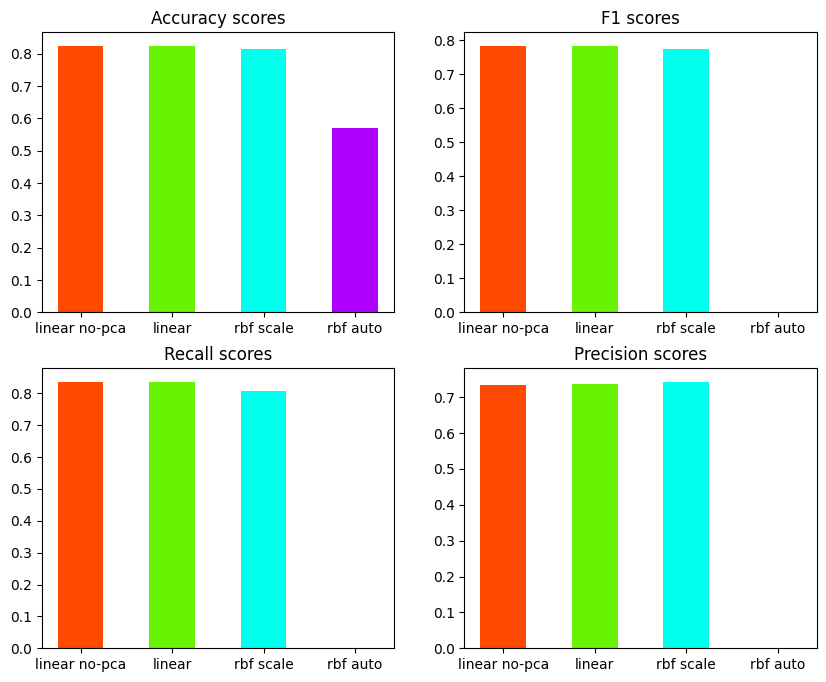

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))

ax[0,0].bar(scores_labels, acc_scores, width=0.5, color=['#ff4900' ,'#66f304', '#00ffec', '#ae00ff'])
ax[0,0].set_title('Accuracy scores')

ax[0,1].bar(scores_labels, f1_scores, width=0.5, color=['#ff4900' ,'#66f304', '#00ffec', '#ae00ff'])
ax[0,1].set_title('F1 scores')

ax[1,0].bar(scores_labels, rec_scores, width=0.5, color=['#ff4900' ,'#66f304', '#00ffec', '#ae00ff'])
ax[1,0].set_title('Recall scores')

ax[1,1].bar(scores_labels, pre_scores, width=0.5, color=['#ff4900' ,'#66f304', '#00ffec', '#ae00ff'])
ax[1,1].set_title('Precision scores')

plt.show()

## Bayes

In [46]:
from sklearn.naive_bayes import GaussianNB

In [47]:
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)
print(train_vectors.shape, test_vectors.shape)

(6851, 14271) (762, 14271)


In [51]:
bayes = GaussianNB()
bayes.fit(train_vectors.toarray(), y_train)

train_pred = bayes.predict(train_vectors.toarray())
test_pred = bayes.predict(test_vectors.toarray())

print('Accuracy in train set:', accuracy_score(train_pred, y_train))
print('Accuracy in test set:', accuracy_score(test_pred, y_test))

print('\nF1 score in train set:', f1_score(train_pred, y_train))
print('F1 score in test set:', f1_score(test_pred, y_test))

print('\nPrecision in train set:', precision_score(train_pred, y_train))
print('Precision in test set:', precision_score(test_pred, y_test))

print('\nRecall in train set:', recall_score(train_pred, y_train))
print('Recall in test set:', recall_score(test_pred, y_test))

Accuracy in train set: 0.8841045102904685
Accuracy in test set: 0.6207349081364829

F1 score in train set: 0.8811733014067644
F1 score in test set: 0.6436498150431565

Precision in train set: 1.0
Precision in test set: 0.7981651376146789

Recall in train set: 0.7875869448903157
Recall in test set: 0.5392561983471075
